In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user lazypredict

In [159]:
export PATH=/Library/TeX/texbin:$PATH

SyntaxError: invalid syntax (<ipython-input-159-c2a3b71f4a9e>, line 1)

In [3]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Base packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import string as st
%matplotlib inline

# Helper packages
import time
import os
import pickle
import re

# Preprocessing packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Machine Learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Scoring packages
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

## Tokenizer helper

Function which helps preserve special characters during tokenization

In [5]:
def tokenizer(x):
    r='!"#$%&;()*+,-./:;<=>?\'@[\\]^_`{|}~'
    to_replace=[re.escape(i) for i in r]

    replace_with=[' '+i+' ' for i in r]
    x=x.lower()
    x=pd.DataFrame([x])[0].replace(to_replace,replace_with,regex=True)[0]
    return(x)
 
corpus=pd.DataFrame(["That's an example.",
"Don't ignore it!",
"This is another example.",
"50$ is a price:-) !&!!^)",
"Look @predictivehacks for more hacks",
"These are hashtags #predictivehacks #datascience #100%fun"],columns=['sentences'])



In [6]:
seed = 170280378

In [7]:
os.getcwd()

'C:\\Users\\User\\Desktop\\PROJECT WORK\\Jupyter Repo'

In [8]:
# Read in DDoS
df = pd.read_csv("DDoS/DDoS.csv", usecols=["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol", "Label"])

In [9]:
# Quick inspection
df.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Label
0,192.168.4.118,4504,203.73.24.75,80,6,ddos
1,192.168.4.118,4504,203.73.24.75,80,6,ddos
2,192.168.4.118,4505,203.73.24.75,80,6,ddos
3,192.168.4.118,4505,203.73.24.75,80,6,ddos
4,192.168.4.118,4506,203.73.24.75,80,6,ddos


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12794627 entries, 0 to 12794626
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Src IP    object
 1   Src Port  int64 
 2   Dst IP    object
 3   Dst Port  int64 
 4   Protocol  int64 
 5   Label     object
dtypes: int64(3), object(3)
memory usage: 585.7+ MB


In [11]:
# showing missing values
print(df.isna().sum())
df[df.isna().any(axis=1)]

Src IP      0
Src Port    0
Dst IP      0
Dst Port    0
Protocol    0
Label       0
dtype: int64


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Label


In [12]:
# Remove missing values

df.dropna(axis=0, inplace=True)

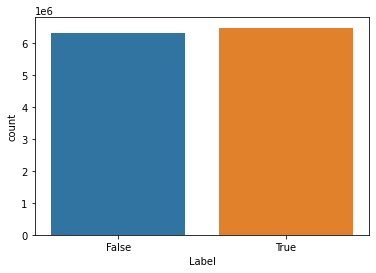

In [13]:
# The label is formatted as string instead of the normal "1"
sns.countplot(df["Label"]=="ddos")

In [14]:
# Well-balanced data set
(df["Label"] == "ddos").sum() / len(df["Label"])

0.5058879012260381


### CountVectorizer
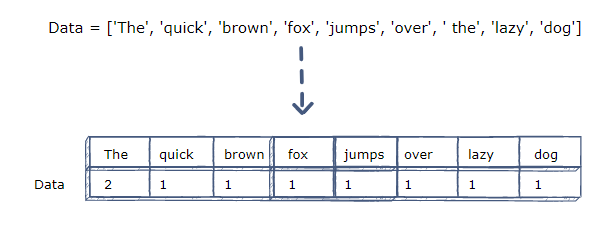

### Common hyperparameters

- min and max_df, ignore terms that have a frequency below or above a certain threshold. Default is 1 so no terms ignored.
- stop_words: Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. 

In [15]:
# Not relevant here
# df[df["Sentence"].str.contains("and")]

In [16]:
# punctuation also features prominently
# df[df["Sentence"].str.contains("'")]

# Reducing here as the dataframe is too big
Standardise at 10, 000 rows total


In [17]:
df["Label"]

0             ddos
1             ddos
2             ddos
3             ddos
4             ddos
             ...  
12794622    Benign
12794623    Benign
12794624    Benign
12794625    Benign
12794626    Benign
Name: Label, Length: 12794627, dtype: object

In [18]:
# Note: Can probably load more rows into this dataset as there will probably be less features compared to SQLi and XSS
df = df.groupby("Label").apply(pd.DataFrame.sample, frac=0.0007816).reset_index(drop=True)

In [19]:
# Still preserves the same ratio of values
(df["Label"] == "ddos").sum() / len(df["Label"])

0.5059

In [20]:
df

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Label
0,172.31.64.118,54235,172.31.0.2,53,17,Benign
1,172.31.66.123,51902,169.254.169.254,80,6,Benign
2,151.101.64.217,443,172.31.69.14,52655,6,Benign
3,172.31.66.84,53434,23.15.8.160,443,6,Benign
4,192.168.10.3,60927,192.168.10.1,53,17,Benign
...,...,...,...,...,...,...
9995,52.14.136.135,51357,172.31.69.25,80,6,ddos
9996,172.31.69.28,80,18.219.9.1,65249,6,ddos
9997,18.218.229.235,60153,172.31.69.28,80,6,ddos
9998,172.31.69.25,80,18.219.193.20,36842,6,ddos


In [21]:
# Need to split IP addresses by "." for further processing

src_ip_split = df["Src IP"].str.split(".", n = 3, expand = True)
df["Src IP 1"] = src_ip_split[0]
df["Src IP 2"] = src_ip_split[1]
df["Src IP 3"] = src_ip_split[2]   
df["Src IP 4"] = src_ip_split[3]  

   

In [22]:
dst_ip_split = df["Dst IP"].str.split(".", n = 3, expand = True)
df["Dst IP 1"] = dst_ip_split[0]
df["Dst IP 2"] = dst_ip_split[1]
df["Dst IP 3"] = dst_ip_split[2]
df["Dst IP 4"] = dst_ip_split[3]

In [23]:
y=df["Label"]

In [24]:
# Convert y to 0 and 1
# Should be numerical
y.replace({"Benign": 0, 'ddos': 1}, inplace=True)

In [25]:
# Remove old columns
df.drop(["Src IP", "Dst IP", "Label"], axis=1, inplace=True)

In [26]:
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: Label, Length: 10000, dtype: int64

In [27]:
df

,Src Port,Dst Port,Protocol,Src IP 1,Src IP 2,Src IP 3,Src IP 4,Dst IP 1,Dst IP 2,Dst IP 3,Dst IP 4
0,54235,53,17,172,31,64,118,172,31,0,2
1,51902,80,6,172,31,66,123,169,254,169,254
2,443,52655,6,151,101,64,217,172,31,69,14
3,53434,443,6,172,31,66,84,23,15,8,160
4,60927,53,17,192,168,10,3,192,168,10,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,51357,80,6,52,14,136,135,172,31,69,25
9996,80,65249,6,172,31,69,28,18,219,9,1
9997,60153,80,6,18,218,229,235,172,31,69,28
9998,80,36842,6,172,31,69,25,18,219,193,20


In [28]:
df.dtypes

Src Port     int64
Dst Port     int64
Protocol     int64
Src IP 1    object
Src IP 2    object
Src IP 3    object
Src IP 4    object
Dst IP 1    object
Dst IP 2    object
Dst IP 3    object
Dst IP 4    object
dtype: object

In [29]:
# Need to confirm the int64-based columns to String
# This prevents algorithms from treating them as numerical values

df["Src Port"] = df["Src Port"].astype("str")
df["Dst Port"] = df["Dst Port"].astype("str")
df["Protocol"] = df["Protocol"].astype("str")

In [30]:
X=df

In [31]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=seed)

In [32]:
# dummy encoding of categorical features
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown = 'ignore')

In [33]:
X_train = ohe.fit_transform(X_train).toarray()

In [34]:
X_test = ohe.transform(X_test).toarray()

In [35]:
ohe_pickle = "DDoS_ohe_pickle.sav"
pickle.dump(ohe, open(ohe_pickle, "wb"))
time_taken = []

# Hyperparameter tuning


### Decision Tree

In [36]:
train_accuracy_score = []

In [37]:
decision_tree = DecisionTreeClassifier(random_state=seed)

In [38]:
dt_parameters = {'max_features': ['log2', 'sqrt','auto', None], 
              'criterion': ['entropy', 'gini'],
                 'splitter':['best', 'random'],
                'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 5, 10],
              'min_samples_leaf': [2, 3, 5, 10]
             }

In [39]:

best_dt = RandomizedSearchCV(decision_tree, dt_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
dt_start = time.time()
best_dt.fit(X_train, y_train)
dt_end = time.time()
dt_time_taken = (dt_end-dt_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini, score=0.509, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini, score=0.510, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=log2, max_depth=2, criterion=gini 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_feature

[CV]  splitter=best, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=2, criterion=gini, score=0.648, total=   0.4s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.5s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini, score=0.515, total=   0.3s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   10.9s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini, score=0.630, total=   0.3s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   11.3s remaining:    0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=10, max_features=sqrt, max_depth=2, criterion=gini 
[CV]  splitter=b

[CV]  splitter=random, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=2, criterion=entropy, score=0.521, total=   0.4s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   33.6s finished


In [40]:
print(dt_time_taken)

0.7524882984161377


In [41]:
time_taken.append(dt_time_taken)

In [42]:
best_dt.best_params_

{'splitter': 'best',
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 50,
 'criterion': 'entropy'}

In [43]:
dt_pickle = "DDoS_dt_pickle.sav"
pickle.dump(best_dt, open(dt_pickle, "wb"))

In [44]:
dt_accuracy = best_dt.best_score_

In [45]:
dt_accuracy

0.99975

In [46]:
train_accuracy_score.append(dt_accuracy)

In [47]:
train_accuracy_score

[0.99975]

### Random Forest

In [48]:
random_forest = RandomForestClassifier(random_state=seed)

In [49]:
rf_parameters = {"n_estimators":[10, 50, 100],
                 "max_features":["log2", "sqrt", "auto", None],
                 "criterion":["entropy", "gini"],
                 "max_depth":[2, 3, 5, 10, 50],
                 "min_samples_split":[2, 3, 5],
                 "min_samples_leaf":[2, 3, 5]
}

In [50]:
best_rf = RandomizedSearchCV(random_forest, rf_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
rf_start = time.time()
best_rf.fit(X_train, y_train)
rf_end = time.time()
rf_time_taken = (rf_end-rf_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini, score=0.833, total=   0.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini, score=0.732, total=   0.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=log2

[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, score=0.842, total=   0.5s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 19.1min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini, score=0.994, total=   2.2s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 19.1min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini, score=0.992, total=   2.2s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 19.2min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=3, min_samples_leaf=5, max_features=sqrt, max_depth=3, criterion=gini 
[CV] 

[CV]  n_estimators=100, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=2, criterion=entropy, score=0.964, total= 1.6min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 38.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 38.2min finished


In [51]:
print(rf_time_taken)

49.53163662910461


In [52]:
time_taken.append(rf_time_taken)

In [53]:
best_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': None,
 'max_depth': 10,
 'criterion': 'entropy'}

In [54]:
rf_pickle = "DDoS_rf_pickle.sav"
pickle.dump(best_rf, open(rf_pickle, "wb"))


In [55]:
rf_accuracy = best_rf.best_score_

In [56]:
rf_accuracy

0.999625

In [57]:
train_accuracy_score.append(rf_accuracy)

In [58]:
train_accuracy_score

[0.99975, 0.999625]

### SVC

In [59]:
svc = SVC(random_state=seed)

In [60]:
svc_parameters = {"kernel": ["linear", "rbf", "poly"],
                 "gamma": [0.1, 1, 10, 100],
                 "C": [0.1, 1, 10, 100, 1000],
                  "degree": [0, 1, 2, 3, 4, 5, 6]
}

In [61]:
best_svc = RandomizedSearchCV(svc, svc_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
svc_start = time.time()
best_svc.fit(X_train, y_train)
svc_end = time.time()
svc_time_taken = (svc_end-svc_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=1.000, total= 2.8min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=1.000, total= 2.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=1.000, total= 2.9min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.5min remaining:    0.0s
[CV] kernel=linear, gamma=10, degree=5, C=1000 .......................
[CV]  kernel=linear, gamma=10, degree=5, C=1000, score=1.000, total= 3.0min
[Parallel(n_jobs=1)]: Done   4

[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.507, total= 9.2min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 247.0min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.507, total= 9.1min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 256.1min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.507, total= 9.1min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 265.1min remaining:    0.0s
[CV] kernel=poly, gamma=1, degree=0, C=10 ............................
[CV]  kernel=poly, gamma=1, degree=0, C=10, score=0.507, total= 9.1min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 274.2min remaining:    0.0s
[CV] kernel=rbf, gamma=100, degree=4, C=0.1 ..........................
[CV]  kernel=rbf, gamma=100, degree=4, C=0.1, score=0.516, total= 9.3min
[Parallel(n_jobs=1)]: Done  41 out 

In [62]:
print(svc_time_taken)

430.8378652858734


In [63]:
time_taken.append(svc_time_taken)

In [64]:
svc_pickle = "DDoS_svc_pickle.sav"
pickle.dump(best_svc, open(svc_pickle, "wb"))


In [65]:
best_svc.best_params_

{'kernel': 'linear', 'gamma': 10, 'degree': 5, 'C': 1000}

In [66]:
svc_accuracy = best_svc.best_score_

In [67]:
svc_accuracy

1.0

In [68]:
train_accuracy_score.append(svc_accuracy)

In [69]:
train_accuracy_score

[0.99975, 0.999625, 1.0]

## Logistic REgression

In [70]:
lr = LogisticRegression(random_state=seed)

In [71]:
lr_parameters = {
     'penalty' : ["l2", None],
    'C' : [0.1, 1.0, 10, 100],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter":[5, 10, 25, 50, 75, 100],
    "multi_class": ["auto", "ovr", "multinomial"]
}

In [72]:
best_lr = RandomizedSearchCV(lr, lr_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
lr_start = time.time()
best_lr.fit(X_train, y_train)
lr_end = time.time()
lr_time_taken = (lr_end-lr_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1 
[CV]  solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, 

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  7.3min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  7.3min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  7.3min remaining:    0.0s
[CV] solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1 
[CV]  solver=newton-cg, penalty=None, multi_class=multinomial, max_iter=100, C=0.1, score=nan, total=   0.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.3min remaining:    0.0s
[CV] solver=liblinear, penalty=l2, multi_class=multinomial, max_iter=10, C=1.0 
[CV]  solver=liblinear, 

In [73]:
print(lr_time_taken)

10.093187422752381


In [74]:
time_taken.append(lr_time_taken)

In [75]:
best_lr.best_params_

{'solver': 'saga',
 'penalty': 'l2',
 'multi_class': 'auto',
 'max_iter': 100,
 'C': 10}

In [76]:
lr_pickle = "DDoS_lr_pickle.sav"
pickle.dump(best_lr, open(lr_pickle, "wb"))

In [77]:
lr_accuracy = best_lr.best_score_

In [78]:
lr_accuracy

1.0

In [79]:
train_accuracy_score.append(lr_accuracy)

In [80]:
train_accuracy_score

[0.99975, 0.999625, 1.0, 1.0]

## KNeighbours

In [81]:
knn = KNeighborsClassifier()

In [82]:
knn_parameters = {"n_neighbors": [1, 5, 10, 25, 50, 75, 100],
                  "weights": ["uniform", "distance"],
                  "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                  "leaf_size": [1, 5, 10, 20, 30, 35, 50]
    
}

In [83]:
best_knn = RandomizedSearchCV(knn, knn_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
knn_start = time.time()
best_knn.fit(X_train, y_train)
knn_end = time.time()
knn_time_taken = (knn_end-knn_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.991, total= 2.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.988, total= 2.0min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree, score=0.990, total= 2.0min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.1min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=50, algorithm=ball_tree 
[CV]  weights=un

[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.990, total= 3.0min
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 51.7min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto ..
[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.990, total= 2.8min
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 54.5min remaining:    0.0s
[CV] weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto ..
[CV]  weights=uniform, n_neighbors=100, leaf_size=30, algorithm=auto, score=0.989, total= 3.1min
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 57.6min remaining:    0.0s
[CV] weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree .
[CV]  weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree, score=0.991, total= 7.3min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 64.9min remaining:    0.0s
[CV] weights=uniform, n_neighbors=75, leaf_size=5, algorithm=kd_tree .
[CV]  w

In [84]:
print(knn_time_taken)

139.63289738178253


In [85]:
time_taken.append(knn_time_taken)

In [86]:
best_knn.best_params_

{'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 5, 'algorithm': 'brute'}

In [87]:
knn_pickle = "DDoS_knn_pickle.sav"
pickle.dump(best_knn, open(knn_pickle, "wb"))

In [88]:
knn_accuracy = best_knn.best_score_

In [89]:
knn_accuracy

0.999625

In [90]:
train_accuracy_score.append(knn_accuracy)

In [91]:
train_accuracy_score

[0.99975, 0.999625, 1.0, 1.0, 0.999625]

## Multinomial NB

Special case with few hyperparameters to tune (Reduced)

In [92]:
nb = MultinomialNB()

In [93]:
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [94]:
nb_parameters = {"alpha": [0, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  "class_prior": [None],
                  "fit_prior": [True, False]
    
}

In [95]:
best_nb = RandomizedSearchCV(nb, nb_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
nb_start = time.time()
best_nb.fit(X_train, y_train)
nb_end = time.time()
nb_time_taken = (nb_end-nb_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.998, total=   0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.999, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=1.000, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=0.001 ..................
[CV]  fit_prior=False, class_prior=None, alpha=0.001, score=0.999, total=   0.3s
[Parallel(

[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.994, total=   0.3s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   14.5s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.996, total=   0.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   14.9s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.994, total=   0.3s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   15.2s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.996, total=   0.3s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   15.6s remaining:    0.0s
[CV] fit_prior=False, class_prior=None, alpha=10 .....................
[CV]  fit_prior=False, class_prior=None, alpha=10, score=0.991, total=   0.3s
[Paral

In [96]:
print(nb_time_taken)

0.40044905185699464


In [97]:
time_taken.append(nb_time_taken)

In [98]:
best_nb.best_params_

{'fit_prior': False, 'class_prior': None, 'alpha': 0.001}

In [99]:
nb_pickle = "DDoS_nb_pickle.sav"
pickle.dump(best_nb, open(nb_pickle, "wb"))

In [100]:
nb_accuracy = best_nb.best_score_

In [101]:
nb_accuracy

0.9988750000000002

In [102]:
train_accuracy_score.append(nb_accuracy)

In [103]:
train_accuracy_score

[0.99975, 0.999625, 1.0, 1.0, 0.999625, 0.9988750000000002]

## MLPClassifier

In [104]:
nn = MLPClassifier(random_state=seed)

In [105]:
nn.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [106]:
nn_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ["identity", "logistic", "tanh", "relu"],
    'solver': ['sgd', 'adam'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive', "invscaling"],
    "learning_rate_init": [0.001, 0.01]
}
    


In [107]:
best_nn = RandomizedSearchCV(nn, nn_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
nn_start = time.time()
best_nn.fit(X_train, y_train)
nn_end = time.time()
nn_time_taken = (nn_end-nn_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity, score=0.999, total= 2.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.0001, activation=identity, score=1.000, total= 2.1min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50

[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.995, total= 4.3min
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 34.4min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.998, total= 4.3min
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 38.6min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic 
[CV]  solver=sgd, learning_rate_init=0.001, learning_rate=constant, hidden_layer_sizes=(100,), alpha=0.001, activation=logistic, score=0.991, total= 4.2min
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 42.8min remaining:    0.0s
[CV] solver=sgd, learning_rate_init=

[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=1.000, total=  34.7s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed: 62.0min remaining:    0.0s
[CV] solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic 
[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=1.000, total=  56.6s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 63.0min remaining:    0.0s
[CV] solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic 
[CV]  solver=adam, learning_rate_init=0.01, learning_rate=adaptive, hidden_layer_sizes=(50, 100, 50), alpha=0.01, activation=logistic, score=1.000, total=  46.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 63.7min remaining:    0.0s
[CV] s

In [108]:
print(nn_time_taken)

79.14465519428254


In [109]:
time_taken.append(nn_time_taken)

In [110]:
best_nn.best_params_

{'solver': 'adam',
 'learning_rate_init': 0.01,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (50, 100, 50),
 'alpha': 0.1,
 'activation': 'tanh'}

In [111]:
nn_pickle = "DDoS_nn_pickle.sav"
pickle.dump(best_nn, open(nn_pickle, "wb"))

In [112]:
nn_accuracy = best_nn.best_score_

In [113]:
nn_accuracy

1.0

In [114]:
train_accuracy_score.append(nn_accuracy)

In [115]:
train_accuracy_score

[0.99975, 0.999625, 1.0, 1.0, 0.999625, 0.9988750000000002, 1.0]

## XGBClassifier

In [116]:
xgb = XGBClassifier(random_state=seed)

In [117]:
xgb.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [118]:
xgb_parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
}
    


In [119]:
best_xgb = RandomizedSearchCV(xgb, xgb_parameters, n_iter=10, cv=5, random_state=seed, verbose=100, scoring="accuracy")
xgb_start = time.time()
best_xgb.fit(X_train, y_train)
xgb_end = time.time()
xgb_time_taken = (xgb_end-xgb_start)/50

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=1.000, total=  23.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=1.000, total=  23.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.0s remaining:    0.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=3, gamma=1, colsample_bytree=0.6, score=1.000, total=  22.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[CV] subsample=0.8, min_child_

[CV]  subsample=0.8, min_child_weight=10, max_depth=4, gamma=5, colsample_bytree=0.8, score=0.994, total=  31.3s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 15.7min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=1.000, total=  24.9s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 16.1min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.998, total=  24.7s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 16.5min remaining:    0.0s
[CV] subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=7, max_depth=5, gamma=2, colsample_bytree=0.6, score=1.000, total=  23.9s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 16.9mi

In [120]:
print(xgb_time_taken)

31.610014748573303


In [121]:
time_taken.append(xgb_time_taken)

In [122]:
best_xgb.best_params_

{'subsample': 0.8,
 'min_child_weight': 5,
 'max_depth': 3,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [123]:
xgb_pickle = "DDoS_xgb_pickle.sav"
pickle.dump(best_xgb, open(xgb_pickle, "wb"))

In [124]:
xgb_accuracy = best_xgb.best_score_

In [125]:
xgb_accuracy

0.999875

In [126]:
train_accuracy_score.append(xgb_accuracy)

In [127]:
train_accuracy_score

[0.99975, 0.999625, 1.0, 1.0, 0.999625, 0.9988750000000002, 1.0, 0.999875]

# Example confusion matrix

# Load in test data

In [128]:
time_taken

[0.7524882984161377,
 49.53163662910461,
 430.8378652858734,
 10.093187422752381,
 139.63289738178253,
 0.40044905185699464,
 79.14465519428254,
 31.610014748573303]

In [129]:
train_accuracy_score

[0.99975, 0.999625, 1.0, 1.0, 0.999625, 0.9988750000000002, 1.0, 0.999875]

In [130]:
test_accuracy_scores = []
prediction_time = []

In [131]:
classifiers = [best_dt, best_rf, best_svc, best_lr, best_knn, best_nb, best_nn, best_xgb]

In [132]:
for i in classifiers:
    print(i)
    start = time.time()
    y_test_pred = i.predict(X_test)
    end = time.time()
    prediction_time.append(end-start)
    test_accuracy_score = accuracy_score(y_test, y_test_pred)
    test_accuracy_scores.append(test_accuracy_score)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(random_state=170280378),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 10, 50],
                                        'max_features': ['log2', 'sqrt', 'auto',
                                                         None],
                                        'min_samples_leaf': [2, 3, 5, 10],
                                        'min_samples_split': [2, 3, 5, 10],
                                        'splitter': ['best', 'random']},
                   random_state=170280378, scoring='accuracy', verbose=100)
RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=170280378),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 10, 50],
                                        'max_features': ['l

In [133]:
test_accuracy_scores

[0.998, 0.998, 0.9995, 0.9995, 0.9995, 0.9985, 0.999, 1.0]

In [156]:
np.std(test_accuracy_scores)

0.0007071067811865579

In [134]:
results =   {"Algorithm": ["Decision Tree", "Random Forest", "Support Vector Machine", "Logistic Regression",
                               "K Nearest Neighbours", "Naive Bayes", "Neural Network", "XGBoost"],
        "Training/Validation Accuracy": train_accuracy_score,
        "Testing Accuracy": test_accuracy_scores
       }
  



In [135]:
times = {"Algorithm": ["Decision Tree", "Random Forest", "Support Vector Machine", "Logistic Regression",
                               "K Nearest Neighbours", "Naive Bayes", "Neural Network", "XGBoost"],
         
         "Average training time" : time_taken,
         "Prediction time": prediction_time
    
    
}

In [136]:
results_df = pd.DataFrame(results)

In [137]:
results_df

,Algorithm,Training/Validation Accuracy,Testing Accuracy
0,Decision Tree,1.00,1.00
1,Random Forest,1.00,1.00
2,Support Vector Machine,1.00,1.00
3,Logistic Regression,1.00,1.00
4,K Nearest Neighbours,1.00,1.00
5,Naive Bayes,1.00,1.00
6,Neural Network,1.00,1.00
7,XGBoost,1.00,1.00


In [138]:
results_df.to_pickle("DDoS Results Pickle")

In [139]:
results_df.sort_values(by="Training/Validation Accuracy", inplace=True)

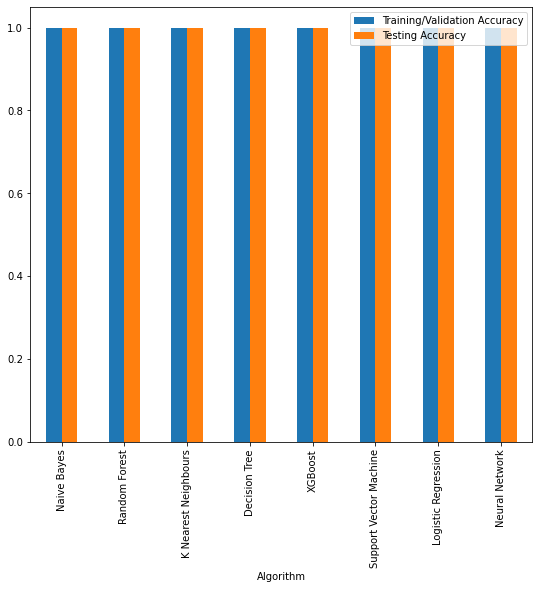

In [140]:
results_df.plot(x="Algorithm", y=["Training/Validation Accuracy", "Testing Accuracy"], kind="bar", figsize=(9,8))

In [141]:
results_df.sort_values(by="Testing Accuracy", inplace=True)

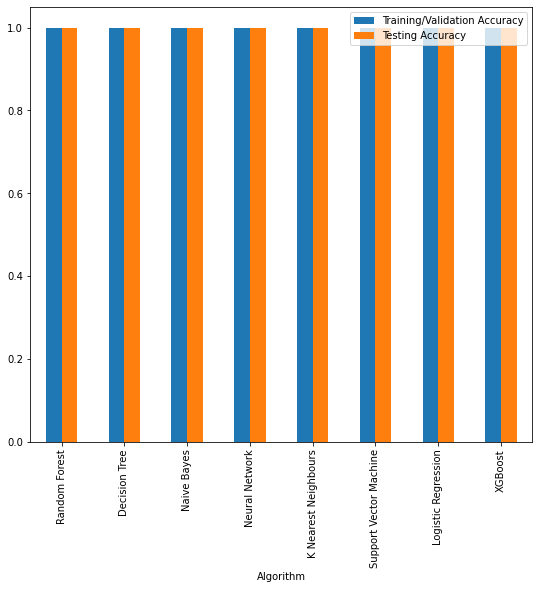

In [142]:
results_df.plot(x="Algorithm", y=["Training/Validation Accuracy", "Testing Accuracy"], kind="bar", figsize=(9,8))

In [143]:
times

{'Algorithm': ['Decision Tree',
  'Random Forest',
  'Support Vector Machine',
  'Logistic Regression',
  'K Nearest Neighbours',
  'Naive Bayes',
  'Neural Network',
  'XGBoost'],
 'Average training time': [0.7524882984161377,
  49.53163662910461,
  430.8378652858734,
  10.093187422752381,
  139.63289738178253,
  0.40044905185699464,
  79.14465519428254,
  31.610014748573303],
 'Prediction time': [0.27426695823669434,
  0.07879090309143066,
  45.88630962371826,
  0.02689194679260254,
  2.2549667358398438,
  0.0298919677734375,
  0.18151640892028809,
  0.3291175365447998]}

In [144]:
time_df = pd.DataFrame(times)

In [145]:
time_df

,Algorithm,Average training time,Prediction time
0,Decision Tree,0.75,0.27
1,Random Forest,49.53,0.08
2,Support Vector Machine,430.84,45.89
3,Logistic Regression,10.09,0.03
4,K Nearest Neighbours,139.63,2.25
5,Naive Bayes,0.40,0.03
6,Neural Network,79.14,0.18
7,XGBoost,31.61,0.33


In [146]:
time_df.to_pickle("DDoS Time Pickle")

In [147]:
time_df.sort_values(by="Prediction time", inplace=True)

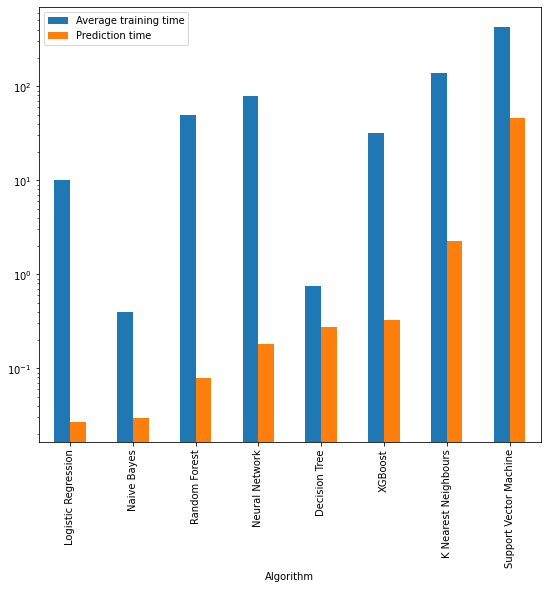

In [148]:
time_df.plot(x="Algorithm", y=["Average training time", "Prediction time"], kind="bar", figsize=(9,8), logy=True)

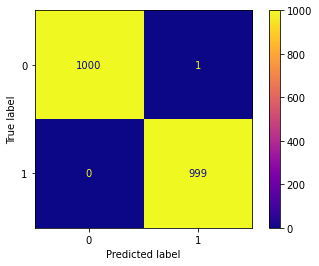

In [152]:
plot_confusion_matrix(best_lr, X_test, y_test, cmap="plasma")

In [ ]:
dumb_grid  = {'penalty': ['l1', 'l2'],'C':[0.001]}
dumb =GridSearchCV(LogisticRegression(),dumb_grid,cv=5,scoring = 'accuracy')
dumb.fit(X_train, y_train)

In [ ]:
dumb.best_estimator_

In [ ]:
dumb.best_score__

In [ ]:
nb_y_test_pred = best_nb.predict(cv_X_test)

In [ ]:
nb_y_test_pred

In [ ]:
indices = [i for i in range(len(y_test)) if y_test[i] != nb_y_test_pred[i]]

In [ ]:
wrong_predictions = test_df.iloc[indices,:]

In [ ]:
wrong_predictions

In [ ]:
time_df

In [ ]:
play_df = pd.DataFrame({'Input': ["class=btn btn-default output_collapsed", "<body onafterprint=alert(1)>"]})

In [ ]:
play_df["Input"] = play_df["Input"].apply(tokenizer)

In [ ]:
play_df

In [ ]:
play_df = cv.transform(play_df["Input"]).toarray()

In [ ]:
play_output = best_random_forest.predict(play_df)

In [ ]:
play_output